In [121]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch.nn import Linear, Dropout
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
import torch.nn.functional
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, make_scorer

In [122]:
classes_path = "../augmented_elliptic_bitcoin_dataset/modified_elliptic_txs_classes.csv"
edges_path = "../augmented_elliptic_bitcoin_dataset/modified_elliptic_txs_edgelist.csv"
features_path = "../augmented_elliptic_bitcoin_dataset/modified_elliptic_txs_features.csv"

classes = pd.read_csv(classes_path)
edges = pd.read_csv(edges_path)
feat_cols = ['txId', 'time_step'] + [f'trans_feat_{i}' for i in range(93)] + [f'agg_feat_{i}' for i in range(72)]
feats = pd.read_csv(features_path, header=None, names=feat_cols)

# Preprocess the classes DataFrame
classes.columns = ['txId', 'label']
df = classes.set_index('txId').join(feats.set_index('txId'))

df.loc[df['time_step'] == -1, 'time_step'] = np.random.randint(1, 49, size=(df['time_step'] == -1).sum())

# Create a mapping for all nodes
all_nodes_dict = {tx_id: i for i, tx_id in enumerate(classes['txId'])}

# Create edges list with all nodes
edges_list = [
    (all_nodes_dict[edges['txId1'][i]], all_nodes_dict[edges['txId2'][i]])
    for i in tqdm(range(len(edges)))
    if edges['txId1'][i] in all_nodes_dict and edges['txId2'][i] in all_nodes_dict
]
edge_index = torch.tensor(edges_list, dtype=torch.long).T

train_data = df[(df['time_step'] >= 1) & (df['time_step'] <= 24)]
val_data = df[(df['time_step'] >= 25) & (df['time_step'] <= 34)]
test_data = df[(df['time_step'] >= 35) & (df['time_step'] <= 49)]

feature_columns = df.columns[2:]

scaler = StandardScaler()
scaled_train_features = scaler.fit_transform(train_data[feature_columns])
scaled_val_features = scaler.transform(val_data[feature_columns])
scaled_test_features = scaler.transform(test_data[feature_columns])

train_features = torch.cat(
    (torch.tensor(train_data['time_step'].values).unsqueeze(1), 
     torch.tensor(scaled_train_features, dtype=torch.float)), dim=1
)
val_features = torch.cat(
    (torch.tensor(val_data['time_step'].values).unsqueeze(1), 
     torch.tensor(scaled_val_features, dtype=torch.float)), dim=1
)
test_features = torch.cat(
    (torch.tensor(test_data['time_step'].values).unsqueeze(1), 
     torch.tensor(scaled_test_features, dtype=torch.float)), dim=1
)

# Convert node features and labels    Parameter to (V) choose features used
#node_features = torch.tensor(df.iloc[:, 1:].values, dtype=torch.float)
time_step = torch.tensor(df['time_step'].values, dtype=torch.float)

# Combine time_step back with scaled features
#node_features = torch.cat((time_step.unsqueeze(1), torch.tensor(scaled_features, dtype=torch.float)), dim=1)
node_features = torch.cat(
    (train_features, val_features, test_features), dim=0
)

label_mapping = {'1': 0, '2': 1, 'unknown': -1, 'suspicious': 0} 
labels = torch.tensor(classes['label'].map(label_mapping).values, dtype=torch.long)

# Create graph data object
data = Data(x=node_features, edge_index=edge_index, y=labels)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
data = data.to(device)


100%|██████████| 326504/326504 [00:02<00:00, 133378.39it/s]


cpu


In [123]:
class_counts = torch.bincount(labels[labels >= 0])  # Exclude invalid labels (e.g., -1)
for class_id, count in enumerate(class_counts):
    print(f"Class {class_id}: {count} elements")

Class 0: 29477 elements
Class 1: 42019 elements


In [124]:
'''time_step_column_index = 0 
time_step = data.x[:, time_step_column_index]

train_mask = (time_step >= 1) & (time_step <= 34)
test_mask = (time_step >= 35) & (time_step <= 49)

train_mask = train_mask.clone().detach().to(torch.bool)
test_mask = test_mask.clone().detach().to(torch.bool)'''

'time_step_column_index = 0 \ntime_step = data.x[:, time_step_column_index]\n\ntrain_mask = (time_step >= 1) & (time_step <= 34)\ntest_mask = (time_step >= 35) & (time_step <= 49)\n\ntrain_mask = train_mask.clone().detach().to(torch.bool)\ntest_mask = test_mask.clone().detach().to(torch.bool)'

In [125]:
train_mask = (time_step >= 1) & (time_step <= 24)
val_mask = (time_step >= 25) & (time_step <= 34)
test_mask = (time_step >= 35) & (time_step <= 49)

# Ensure the masks are boolean tensors
train_mask = train_mask.clone().detach().to(torch.bool)
val_mask = val_mask.clone().detach().to(torch.bool)
test_mask = test_mask.clone().detach().to(torch.bool)

In [126]:
##### Hyperparameters
# embeddings length = 128
# Leaky ReLU
# lr = 0.02
# weight_decay = 0.001
# epochs = 251

embeddings_length = 128
lr = 0.0005
weight_decay = 0.0005
epochs = 501

'''embeddings_length = 100
lr = 0.001
weight_decay = 0.0005
epochs = 1001'''

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# Define GCN model
class GCN(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()
        self.gcn = GCNConv(num_features, embeddings_length)  # GCNConv layer, 3 output channels
        self.dropout = Dropout()
        self.out = Linear(embeddings_length, num_classes)    # Linear layer for classification output
    
    def forward(self, x, edge_index):
        h = torch.nn.functional.leaky_relu(self.gcn(x, edge_index))   # Apply GCN and ReLU
        h = self.dropout(h)
        z = self.out(h)                      # Output layer
        return h, z

# Initialize the model
num_features = data.x.shape[1]  # Number of features (columns in x)
num_classes = 2  # Number of classes (2 in this case)
hidden_dim = embeddings_length
model = GCN(num_features, num_classes).to(device)
print(model)
print(num_classes)

# Loss function and optimizer

valid_labels = classes['label'].map(label_mapping)
valid_labels = valid_labels[valid_labels != -1]  # Exclude 'unknown'

# Convert to a PyTorch tensor for use in the loss function
class_weights_tensor = torch.tensor([0.7, 0.3], dtype=torch.float).to(device)

# Define the loss function with class weights
criterion = torch.nn.CrossEntropyLoss(weight=class_weights_tensor).to(device)

#criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

# Accuracy calculation function
def accuracy(pred_y, y):
    return (pred_y == y).sum() / len(y)

def calculate_metrics(y_true, y_pred, target_class=0):
    precision = precision_score(y_true, y_pred, pos_label=target_class, zero_division=0)
    recall = recall_score(y_true, y_pred, pos_label=target_class, zero_division=0)
    f1 = f1_score(y_true, y_pred, pos_label=target_class, zero_division=0)
    return precision, recall, f1
val_f1_scores = []

# Training loop
for epoch in range(epochs):
    optimizer.zero_grad()
    h, z = model(data.x, data.edge_index)  # h: embeddings, z: logits

    # Exclude unlabeled nodes from the loss calculation
    mask = data.y[train_mask] != -1  
    loss = criterion(z[train_mask][mask], data.y[train_mask][mask]) # Compute loss
    
    loss.backward()                         # Backpropagate
    optimizer.step()                        # Update model parameters

    acc = accuracy(z[train_mask].argmax(dim=1)[mask], data.y[train_mask][mask])  # Calculate accuracy

    model.eval() 
    with torch.no_grad():
        mask_val = data.y[val_mask] != -1  
        val_loss = criterion(z[val_mask][mask_val], data.y[val_mask][mask_val])
        val_acc = accuracy(z[val_mask].argmax(dim=1)[mask_val], data.y[val_mask][mask_val])

        val_y_true = data.y[val_mask][mask_val].cpu().numpy()
        val_y_pred = z[val_mask][mask_val].argmax(dim=1).cpu().numpy()
        val_precision, val_recall, val_f1 = calculate_metrics(val_y_true, val_y_pred)

    train_losses.append(loss.item())
    train_accuracies.append(acc.item())
    val_losses.append(val_loss.item())
    val_accuracies.append(val_acc.item())
    val_f1_scores.append(val_f1)
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch:>3} | Loss: {loss:.2f} | Acc: {acc*100:.2f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}%% | F1 (Val): {val_f1:.4f}')


GCN(
  (gcn): GCNConv(166, 128)
  (dropout): Dropout(p=0.5, inplace=False)
  (out): Linear(in_features=128, out_features=2, bias=True)
)
2
Epoch   0 | Loss: 0.78 | Acc: 51.66 | Val Loss: 0.6923 | Val Acc: 55.46%% | F1 (Val): 0.6803
Epoch  10 | Loss: 0.41 | Acc: 73.79 | Val Loss: 0.4825 | Val Acc: 60.02%% | F1 (Val): 0.7253
Epoch  20 | Loss: 0.33 | Acc: 78.25 | Val Loss: 0.4413 | Val Acc: 62.38%% | F1 (Val): 0.7388
Epoch  30 | Loss: 0.29 | Acc: 83.30 | Val Loss: 0.4396 | Val Acc: 65.64%% | F1 (Val): 0.7510
Epoch  40 | Loss: 0.27 | Acc: 84.84 | Val Loss: 0.4459 | Val Acc: 66.06%% | F1 (Val): 0.7524
Epoch  50 | Loss: 0.25 | Acc: 86.69 | Val Loss: 0.4554 | Val Acc: 67.19%% | F1 (Val): 0.7565
Epoch  60 | Loss: 0.23 | Acc: 87.58 | Val Loss: 0.4668 | Val Acc: 67.50%% | F1 (Val): 0.7577
Epoch  70 | Loss: 0.22 | Acc: 88.41 | Val Loss: 0.4789 | Val Acc: 68.07%% | F1 (Val): 0.7601
Epoch  80 | Loss: 0.21 | Acc: 88.96 | Val Loss: 0.4896 | Val Acc: 68.52%% | F1 (Val): 0.7625
Epoch  90 | Loss: 0.21 |

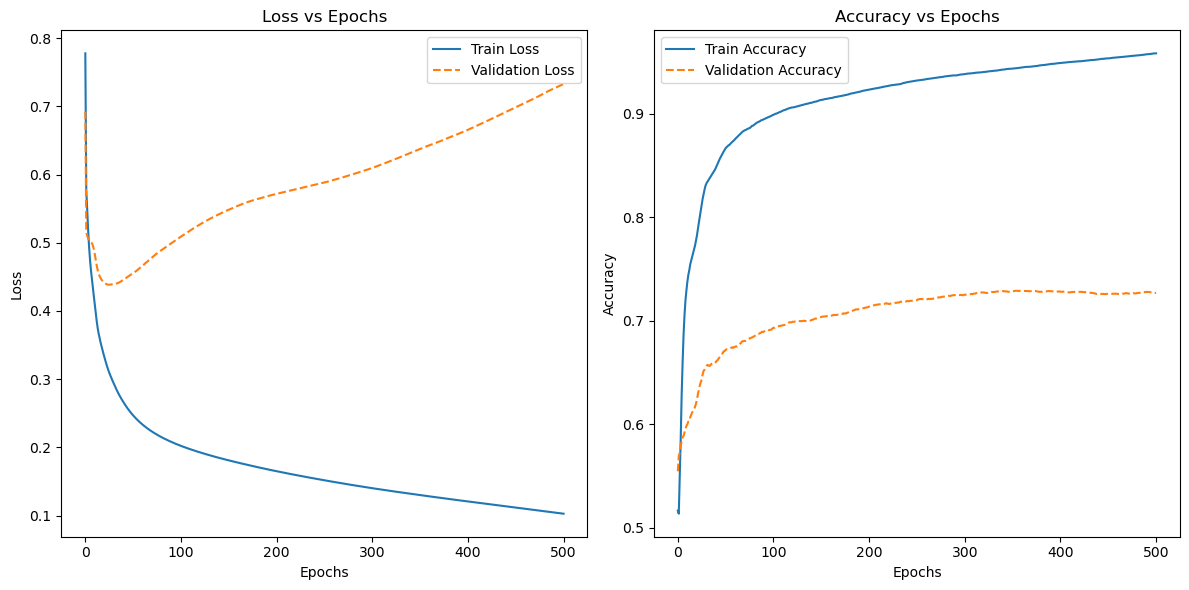

In [127]:
import matplotlib.pyplot as plt

# Plotting the results
plt.figure(figsize=(12, 6))

# Plot Losses
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()

# Plot Accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend()

plt.tight_layout()
plt.show() 

In [128]:
classes_path = "../elliptic_bitcoin_dataset/modified_elliptic_txs_classes.csv"
edges_path = "../elliptic_bitcoin_dataset/modified_elliptic_txs_edgelist.csv"
features_path = "../elliptic_bitcoin_dataset/modified_elliptic_txs_features.csv"

classes = pd.read_csv(classes_path)
edges = pd.read_csv(edges_path)
feat_cols = ['txId', 'time_step'] + [f'trans_feat_{i}' for i in range(93)] + [f'agg_feat_{i}' for i in range(72)]
feats = pd.read_csv(features_path, header=None, names=feat_cols)

# Preprocess the classes DataFrame
classes.columns = ['txId', 'label']
df = classes.set_index('txId').join(feats.set_index('txId'))

# Create a mapping for all nodes
all_nodes_dict = {tx_id: i for i, tx_id in enumerate(classes['txId'])}

# Create edges list with all nodes
edges_list = [
    (all_nodes_dict[edges['txId1'][i]], all_nodes_dict[edges['txId2'][i]])
    for i in tqdm(range(len(edges)))
    if edges['txId1'][i] in all_nodes_dict and edges['txId2'][i] in all_nodes_dict
]
edge_index = torch.tensor(edges_list, dtype=torch.long).T

train_data = df[(df['time_step'] >= 1) & (df['time_step'] <= 24)]
val_data = df[(df['time_step'] >= 25) & (df['time_step'] <= 34)]
test_data = df[(df['time_step'] >= 35) & (df['time_step'] <= 49)]

feature_columns = df.columns[2:]

scaler = StandardScaler()
scaled_train_features = scaler.fit_transform(train_data[feature_columns])
scaled_val_features = scaler.transform(val_data[feature_columns])
scaled_test_features = scaler.transform(test_data[feature_columns])

train_features = torch.cat(
    (torch.tensor(train_data['time_step'].values).unsqueeze(1), 
     torch.tensor(scaled_train_features, dtype=torch.float)), dim=1
)
val_features = torch.cat(
    (torch.tensor(val_data['time_step'].values).unsqueeze(1), 
     torch.tensor(scaled_val_features, dtype=torch.float)), dim=1
)
test_features = torch.cat(
    (torch.tensor(test_data['time_step'].values).unsqueeze(1), 
     torch.tensor(scaled_test_features, dtype=torch.float)), dim=1
)

# Convert node features and labels    Parameter to (V) choose features used
#node_features = torch.tensor(df.iloc[:, 1:].values, dtype=torch.float)
time_step = torch.tensor(df['time_step'].values, dtype=torch.float)

# Combine time_step back with scaled features
#node_features = torch.cat((time_step.unsqueeze(1), torch.tensor(scaled_features, dtype=torch.float)), dim=1)
node_features = torch.cat(
    (train_features, val_features, test_features), dim=0
)

label_mapping = {'1': 0, '2': 1, 'unknown': -1} 
labels = torch.tensor(classes['label'].map(label_mapping).values, dtype=torch.long)

# Create graph data object
data = Data(x=node_features, edge_index=edge_index, y=labels)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
data = data.to(device)




100%|██████████| 234355/234355 [00:01<00:00, 117529.26it/s]


cpu


In [129]:
# Extract node embeddings
model.eval()
with torch.no_grad():
    embeddings, z = model(data.x, data.edge_index)  # h: embeddings

# Ensure alignment of txId and labels with embeddings
# The order in `data.x` corresponds to `classes['txId']` due to how `all_nodes_dict` was built
aligned_df = pd.DataFrame({
    'txId': classes['txId'],  # Use the original node order
    'time_step': time_step.cpu().numpy(),  # Extract time_step from the GCN input
    'label': classes['label']  # Use the original labels
})

# Add embeddings
embeddings_df = pd.concat([aligned_df, pd.DataFrame(embeddings.cpu().numpy())], axis=1)

# Save to CSV
#embeddings_df.to_csv('../data/embeddings_gcn.csv', index=False)


In [130]:
train_mask = (time_step >= 1) & (time_step <= 24)
val_mask = (time_step >= 25) & (time_step <= 34)
test_mask = (time_step >= 35) & (time_step <= 49)

# Ensure the masks are boolean tensors
train_mask = train_mask.clone().detach().to(torch.bool)
val_mask = val_mask.clone().detach().to(torch.bool)
test_mask = test_mask.clone().detach().to(torch.bool)

In [131]:
mask_test = data.y[test_mask] != -1 

predictions = z[test_mask][mask_test].argmax(dim=1).cpu().numpy()
true_labels = data.y[test_mask][mask_test].cpu().numpy()

test_accuracy = accuracy(predictions, true_labels)
precision_ilicit_test = precision_score(true_labels, predictions, pos_label=0)
recall_ilicit_test = recall_score(true_labels, predictions, pos_label=0)
f1_ilicit_test = f1_score(true_labels, predictions, pos_label=0, zero_division=0)

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f'Precision node embeddings (gcn): {precision_ilicit_test}')
print(f'Recall node embeddings (gcn): {recall_ilicit_test}')
print(f'F1 node embeddings (gcn): {f1_ilicit_test}')

Test Accuracy: 7.15%
Precision node embeddings (gcn): 0.06539460177525512
Recall node embeddings (gcn): 1.0
F1 node embeddings (gcn): 0.12276127862162775


In [132]:
embeddings_df.drop(embeddings_df[embeddings_df["label"] == "unknown"].index, inplace=True)
y = embeddings_df['label']
X = embeddings_df.drop(columns=['label'])

In [133]:
X_train_gcn = X[X['time_step'].between(1, 34)]
y_train_gcn = y[X['time_step'].between(1, 34)]

X_test_gcn = X[X['time_step'].between(35, 49)]
y_test_gcn = y[X['time_step'].between(35, 49)]

In [134]:
X_train_gcn = X_train_gcn.drop(columns=['time_step','txId'])
X_test_gcn = X_test_gcn.drop(columns=['time_step','txId'])

In [135]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, make_scorer
from sklearn.model_selection import cross_val_score

clf_gcn = RandomForestClassifier(n_estimators = 100, random_state=42)  
clf_gcn.fit(X_train_gcn, y_train_gcn)
y_pred_gcn = clf_gcn.predict(X_test_gcn)

precision_ilicit_gcn = precision_score(y_test_gcn, y_pred_gcn, pos_label='1')
recall_ilicit_gcn = recall_score(y_test_gcn, y_pred_gcn, pos_label='1')
f1_ilicit_gcn = f1_score(y_test_gcn, y_pred_gcn, pos_label='1')
f1_scorer_gcn = make_scorer(f1_score, pos_label='1')
scores_gcn = cross_val_score(clf_gcn, X_train_gcn, y_train_gcn, cv=5, scoring=f1_scorer_gcn)

print(f'Precision node embeddings (gcn): {precision_ilicit_gcn}')
print(f'Recall node embeddings (gcn): {recall_ilicit_gcn}')
print(f'F1 node embeddings (gcn): {f1_ilicit_gcn}')
print("Cross-validated F1 Score node embeddings (gcn):", scores_gcn.mean())

Precision node embeddings (gcn): 0.6111111111111112
Recall node embeddings (gcn): 0.09141274238227147
F1 node embeddings (gcn): 0.15903614457831325
Cross-validated F1 Score node embeddings (gcn): 0.4392892171520761


In [136]:
X_train_gcn.shape

(29894, 128)

In [137]:
# Remove the unknown (-1) labels by masking them out
valid_labels = labels[labels != -1]

# Count the occurrences of each valid label (0 for illicit, 1 for licit)
label_counts = torch.bincount(valid_labels)

# Print the counts for each label
print(f"Illicit (class 0): {label_counts[0].item()}")
print(f"Licit (class 1): {label_counts[1].item()}")

Illicit (class 0): 4545
Licit (class 1): 42019


In [138]:
train_size = (train_mask).sum().item()
val_size = (val_mask).sum().item()
test_size = (test_mask).sum().item()

# Print the sizes of the sets
print(f"Training set size: {train_size}")
print(f"Validation set size: {val_size}")
print(f"Test set size: {test_size}")

Training set size: 108950
Validation set size: 27315
Test set size: 67504


In [139]:
import torch

# Substituir os valores de 'unknown' (-1) por um valor maior para não interferir na contagem das classes 0 e 1
labels_modified = labels.clone()
labels_modified[labels == -1] = 2  # Substitui -1 por 2, por exemplo

# Calcular a frequência das classes para ajustar os pesos
class_counts = torch.bincount(labels_modified)
total_samples = len(labels)
class_weights = total_samples / (len(class_counts) * class_counts.float())

# Definir os pesos para as classes 0 e 1 (ignorando a classe 'unknown' que foi mapeada para 2)
weights = class_weights[:2]  # Apenas as classes 0 e 1


In [140]:
weights

tensor([14.9446,  1.6165])

In [141]:
class_counts

tensor([  4545,  42019, 157205])